In [1]:
import pandas as pd
import numpy as np
import re
# loading the sources files
from IPython.core.display import display, HTML
tp=pd.read_csv("20231211-Filtered-TPs.csv")
cim=pd.read_csv("20231130-CIM-report.csv")
sp1=pd.read_csv("20231211-SP1.csv")
#For future reference
leninitp=len(tp)
leninicim=len(cim)
leninisp1=len(sp1)



/tmp/ipykernel_228/2677971196.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#Read third party, filter on AC division
tp.columns
tp.head()
tp[['TDPARTY_NAME','TDPARTY_ADDRESS','TDPARTY_POSTAL_CODE',"TDPARTY_CITY","TDPARTY_COUNTRY", 'TDPARTY_PROGRAM']]
# Filtrage uniquement sur les third party AC
display(HTML('<h1>Stats</h1>'))
display(HTML('<b>Third parties in licenses # : </b>'+str(leninitp)))
display(HTML('<b>Supplier in CIM # : </b>'+str(leninicim)))
display(HTML('<b>Supplier in SP1 # : </b>'+str(leninisp1)))


In [3]:
# The country file is used to provide a mapping to all country representation (language and typo). 
countries=pd.read_csv("countries.csv",index_col=0)
# Select the countries when there is a need to substitute
replacements=countries[countries.originalcountry!=countries.tobename]
# Convert the mapping adding some pattern to avoid unwanted replacement 
# (To avoid Airbus is replaced by Airbus Airbusa because us represent the coutry usa)
#replacements.originalcountry="[\\s^]"+replacements.originalcountry+"[\\s$]"
replacements.originalcountry=replacements.originalcountry
replacements.tobename=" "+replacements.tobename
# Replacement of countries to unifed representation (independant from tongue and typo)
replacements=replacements.set_index('originalcountry')
replacements.tobename=replacements.tobename.replace("\s","",regex=True)
# Converting to dict
replacements=replacements.tobename.to_dict()

# Create a single pattern doing all replacement to apply once on every line (for efficency)
rep = dict((re.escape(k), v) for k, v in replacements.items()) 
pattern = re.compile("|".join(rep.keys()))


/tmp/ipykernel_228/1498682475.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.originalcountry=replacements.originalcountry
/tmp/ipykernel_228/1498682475.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  replacements.tobename=" "+replacements.tobename


In [4]:
# This set the country in case where the county information is provided in the name of the thrid party
def deduceContryFromNameInformation(df,acronym,country):
    df.CountryCleansed=df.CountryCleansed.mask((df.CountryCleansed.isna()) & (df.NameCleansed.str.contains( "\\s"+acronym+"[\s]*")),country)
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+acronym+"[\\s]*"," ",regex=True)
    return df
    
def removeFromName(df,toremove):
    df.NameCleansed=df.NameCleansed.str.replace("\\s"+toremove+"[\\s]*"," ",regex=True)
    return df

def removeFromNameCountry(df,toremove):
    df.NameCountryCleansed=df.NameCountryCleansed.str.replace("\\s"+toremove+"[\\s]*"," ",regex=True)
    return df

# Function to clean the name of the commany and creating a column for representation of name + country
def cleanCountryAndName(df):
    dftoreplace=df
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"sas","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.a\.s","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"france","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"french","france")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"ltd","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"united kingdom","united kingdom")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "s\.l","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"s\.l\.","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "slu","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"spanish","spain")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"turkish*","turkey")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"german*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"gmbh*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"deutschland*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"verwaltungs*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "germany*","germany")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgium*","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace,"belgian","belgium")
    dftoreplace=deduceContryFromNameInformation(dftoreplace, "luxembourg","luxembourg")

    
    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud ouest[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssud-ouest[\s]*")),"france")    
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "[\\s]*toulouse[\s]*")),"france")
    dftoreplace.CountryCleansed=dftoreplace.CountryCleansed.mask((dftoreplace.CountryCleansed.isna()) & (dftoreplace.NameCleansed.str.contains( "\\ssl[\s]*")),"spain")
    
    #Remove unrelevant terms from company name 
    dftoreplace.NameCleansed=dftoreplace.NameCleansed.str.replace("\\sprivate[\\s]*"," ",regex=True)

    for country in countries.originalcountry:
        dftoreplace=removeFromName(dftoreplace,country)
        
    # Clean the country name use only english"
    dftoreplace["CountryCleansed"].fillna("",inplace=True)
    dftoreplace["CountryCleansed"]=dftoreplace["CountryCleansed"].apply(lambda x:pattern.sub(lambda m: rep[re.escape(m.group(0))], x))
    dftoreplace["CountryCleansed"].replace(" ","",regex=True,inplace=True)
    dftoreplace["CountryCleansed"].replace("-","",regex=True,inplace=True)
    dftoreplace=removeFromName(dftoreplace,"sa")
    dftoreplace=removeFromName(dftoreplace,"gmbh")
    dftoreplace=removeFromName(dftoreplace,"sl")
    dftoreplace=removeFromName(dftoreplace,"private")
    dftoreplace=removeFromName(dftoreplace,"co")
    dftoreplace=removeFromName(dftoreplace,"kg")
    dftoreplace=removeFromName(dftoreplace,"verwaltungs")
    dftoreplace=removeFromName(dftoreplace,"gesellschaft")
    dftoreplace["NameCountryCleansed"]=dftoreplace.NameCleansed+ " " +dftoreplace["CountryCleansed"]
    df.NameCountryCleansed=df.NameCountryCleansed.str.replace("-"," ")
    return dftoreplace

In [5]:
sp1.columns


Index(['supp_no', 'supp_name', 'supp_address', 'supp_postal_code', 'supp_city',
       'supp_country_code', 'supp_country_name_en', 'supp_cage_code',
       'division', 'all_text'],
      dtype='object')

In [6]:
# We create a cleansed name in the TP referential referential

tp["indexcol"]=tp.index
#tp=tp[tp.LICENSE_DIVISION=="AC"]
print("Tp with no name",tp[tp.TDPARTY_NAME.isna()])
print("Tp with no country")
print(tp[tp.TDPARTY_COUNTRY.isna()]["TDPARTY_NAME"])
tp=tp[~tp.TDPARTY_NAME.isna()]
#Filtrage sur la division
tp.to_csv("tp-cleansed.csv")
tp["NameCleansed"]=tp.TDPARTY_NAME.str.lower()
tp["CountryCleansed"]=tp.TDPARTY_COUNTRY.str.lower()
tp["CleansedAddress"]=tp['TDPARTY_ADDRESS'] +" " + tp['TDPARTY_POSTAL_CODE'] +" "+ tp['TDPARTY_CITY']
tp["CleansedAddress"]=tp["CleansedAddress"].str.lower()
tp["usablename"]=True



display(HTML('<b>Unique third party name #:</b>'+str(len(tp["NameCleansed"].unique()))))
lenfintp=len(tp)
display(HTML('<b>Removed third party after cleansing #:</b>'+str(lenfintp-leninitp)))
tp.head()


tp=cleanCountryAndName(tp)

tp.loc[tp.CountryCleansed.isna(),"usablename"]=False

tp.NameCountryCleansed[611]


Tp with no name Empty DataFrame
Columns: [FILENAME, LICENSE_NBR, TDPARTY_NAME, TDPARTY_ROLE, TDPARTY_COUNTRY, TDPARTY_ADDRESS, TDPARTY_ARP_ID, ARP_needreview, TDPARTY_FLAG, LICENSE_DIVISION, LICENSE_PROGRAM, TDPARTY_CITY, TDPARTY_POSTAL_CODE, TDPARTY_PROGRAM, indexcol]
Index: []
Tp with no country
20                 ALTRAN Sud Ouest
86                 ALTRAN Sud Ouest
168                 FLIR System INC
301           Airbus Operations SAS
611                      Airbus SAS
                   ...             
8284                     AIRBUS SAS
8451      AIRBUS DEFENSE & SPACE SA
8534    AIRBUS DEFENCE AND SPACE SA
8535    AIRBUS DEFENCE AND SPACE SA
8582                     AIRBUS SAS
Name: TDPARTY_NAME, Length: 106, dtype: object


'airbus  france'

In [7]:
# We create a cleansed name in the CIM referential
cim["index"]=cim.index
cim[['Name','Country Name','Street',"Zip code",'City','Country (Address)']]
cim=cim[~cim.Name.isna()]
cim["NameCleansed"]=cim.Name.str.lower()
cim["CountryCleansed"]=cim["Country Name"].str.lower()
cim['Street'].fillna("",inplace=True)
cim['Street (continued)'].fillna("",inplace=True)
cim['Zip code'].fillna("",inplace=True)
cim['City'].fillna("",inplace=True)
cim["CleansedAddress"]= cim['Street']+" " +  cim['Street (continued)']+" " + cim['Zip code']+" " + cim['City']
cim["CleansedAddress"]=cim["CleansedAddress"].str.lower()
cim=cleanCountryAndName(cim)

print("Nombre de supplier name dans cim",len(cim["NameCleansed"].unique()))




Nombre de supplier name dans cim 1810


In [8]:
#Nettoyage des supplier name
sp1["index"]=sp1.index
sp1=sp1[~sp1.supp_name.isna()]

sp1["NameCleansed"]=sp1.supp_name.str.lower()
sp1["CountryCleansed"]=sp1.supp_country_name_en.str.lower()
sp1["CleansedAddress"]=sp1['supp_address']+" " + sp1['supp_postal_code']+" " + sp1['supp_city']
sp1["CleansedAddress"]=sp1["CleansedAddress"].str.lower()
print("Nombre de supplier name dans sp1",len(sp1["NameCleansed"].unique()))
sp1=cleanCountryAndName(sp1)

sp1.NameCountryCleansed

Nombre de supplier name dans sp1 42930


0                        atis iberica derichebourg spain
1                                             jvd france
2                wolf gustav seil und drahtwerke germany
3                                        caillau  france
4        gardner aerospace   derby limited unitedkingdom
                              ...                       
49046               aertec industrial engineering  spain
49047                  alestis tecnobahia montajes spain
49048                       ultra precision  switzerland
49049                              drosg & . switzerland
49050                                     sapelem france
Name: NameCountryCleansed, Length: 49051, dtype: object

In [9]:
corpusname=pd.concat([cim.NameCountryCleansed,tp.NameCountryCleansed,sp1.NameCountryCleansed])
corpusname[0]




0       nortel networks y &  germany
0             entserv  unitedkingdom
0    atis iberica derichebourg spain
Name: NameCountryCleansed, dtype: object

In [10]:
#Based on the corpus of name we create a matrix of association
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer(strip_accents="ascii")
features = vectorizer.fit(corpusname)

tpnamevect=vectorizer.transform(tp.NameCountryCleansed)
cimnamevect=vectorizer.transform(cim.NameCountryCleansed)
sp1namevect=vectorizer.transform(sp1.NameCountryCleansed)

# Renormalize so that if country is present twice in name and in country, it is counted only once

tpnamevect=(tpnamevect>0)*1
cimnamevect=(cimnamevect>0)*1
sp1namevect=(sp1namevect>0)*1



In [11]:
tp.NameCountryCleansed[14]

'capgemini  india'

In [12]:
# We compute a list giving if two name are similar
from sklearn.metrics.pairwise import cosine_similarity


similaritycim=cosine_similarity(tpnamevect,cimnamevect)
similaritysp1=cosine_similarity(tpnamevect,sp1namevect)


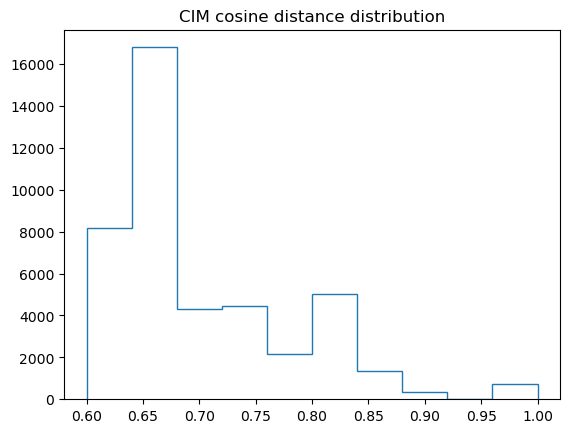

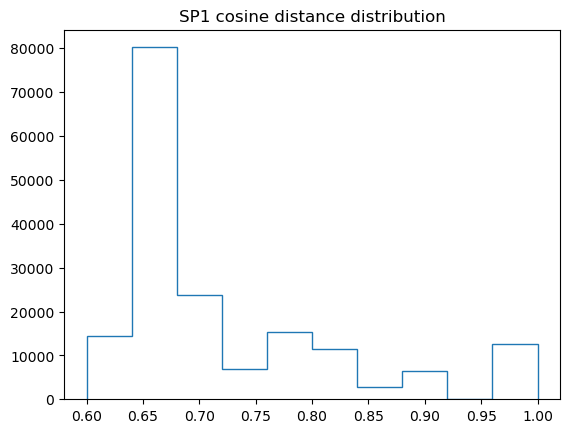

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

counts, bins =np.histogram(similaritycim,range=[.6,1])
plt.stairs(counts, bins)
plt.title("CIM cosine distance distribution")
plt.show()

counts, bins =np.histogram(similaritysp1,range=[.6,1])
plt.stairs(counts, bins)
plt.title("SP1 cosine distance distribution")
plt.show()
#hist

In [14]:
seuil=.82
similarnamecim=np.where(similaritycim>seuil)
similarnamesp1=np.where(similaritysp1>seuil)
maxsimilarnamecim=np.argmax(similaritycim,axis=1)
maxsimilarnamesp1=np.argmax(similaritysp1,axis=1)



print("Exploration de CIM")
for i in range (1,2):
#    print(tp.NameCountryCleansed.iloc[similarnamecim[0][i]])
    print(tp.iloc[similarnamecim[0][i],2])
#    print(cim.NameCountryCleansed.iloc[similarnamecim[1][i]])
    print(cim.iloc[similarnamecim[1][i],3])
    print("----------")

print("===========")

print("Exploration de SP1")
for i in range (1,2):
    print(tp.NameCountryCleansed.iloc[similarnamesp1[0][i]])
    print(sp1.iloc[similarnamesp1[1][i],1])
    print("----------")



#from scipy import spatial
#np.where((tpnamevect.getrow(14).toarray()>0))
#cimnamevect.getrow(77).toarray()[0]

##spatial.distance.cosine(cimnamevect.getrow(14).toarray()[0], tpnamevect.getrow(77).toarray()[0])

#features.inverse_transform(tpnamevect.getrow(14))
#features.inverse_transform(cimnamevect.getrow(77))
#np.where(tpnamevect.getrow(14).toarray()>0)

Exploration de CIM
Airbus
AIRBUS
----------
Exploration de SP1
esg elektroniksystem und logistik gmbh germany
ESG Elektroniksystem - und Logistik-GmbH
----------


In [15]:
sp1.iloc[similarnamesp1[1][i],:]


supp_no                                                             C3002
supp_name                        ESG Elektroniksystem - und Logistik-GmbH
supp_address                                                          NaN
supp_postal_code                                                      NaN
supp_city                                                             NaN
supp_country_code                                                      DE
supp_country_name_en                                              Germany
supp_cage_code                                                        NaN
division                                                              ADS
all_text                [ADS]; C3002; ESG Elektroniksystem - und Logis...
index                                                               36150
NameCleansed                     esg elektroniksystem - und logistik-gmbh
CountryCleansed                                                   germany
CleansedAddress                       

In [16]:
len(similarnamecim[0])



3167

In [17]:
# Creates the proposal in CIM and SP1 correspondance
tp["idcim"]=""
tp["candidatscim"]=""
tp["probacim"]=""
tp["cleanednamecountrycim"]=""
tp["nbcandidatesonnamecim"]=""


tp["idsp1"]=""
tp["candidatssp1"]=""
tp["probasp1"]=""
tp["cleanednamecountrysp1"]=""
tp["nbcandidatesonnamesp1"]=""

indexcim=tp.columns.get_loc("idcim")
indexcandidatscim=tp.columns.get_loc("candidatscim")
indexprobacim=tp.columns.get_loc("probacim")
indexprobasp1=tp.columns.get_loc("probasp1")

# Affectation des proposition suppérieure à 0.9. Listing potentials id in idcim
for i in range(len(similarnamecim[0])):
    tp.iloc[similarnamecim[0][i],indexprobacim]=min(similaritycim[similarnamecim[0][i]][np.where(similaritycim[similarnamecim[0][i]]>seuil)])
    tp.iloc[similarnamecim[0][i],indexcim]=tp.iloc[similarnamecim[0][i],indexcim]+str(similarnamecim[1][i])+","
    tp.iloc[similarnamecim[0][i],indexcandidatscim]=tp.iloc[similarnamecim[0][i],indexcandidatscim]+cim.iloc[similarnamecim[1][i],3].replace("[,\n]"," ")+",\n"

# Recuppération du nombre de proposition
unique, counts = np.unique(similarnamecim[0], return_counts=True)
countcim=dict(zip(unique, counts))
for i in countcim:
    tp.loc[i,"nbcandidatesonnamecim"]=countcim[i]

# Dans le cas où la proba est inférieure à 0.8
tpblank=tp[tp.idcim==""]
for index, row in tpblank.iterrows():
    idcim=maxsimilarnamecim[row.indexcol]
    proba = similaritycim[row.indexcol,idcim]
    if(proba>0.5):
        tp.at[row.indexcol,"idcim"]=idcim
        tp.at[row.indexcol,"candidatscim"]=cim.loc[idcim,"Name"]
        tp.at[row.indexcol,"cleanednamecountrycim"]=cim.loc[idcim,"NameCountryCleansed"]
        tp.at[row.indexcol,"probacim"]=similaritycim[row.indexcol,idcim]

# SP1 

# Affectation des proposition suppérieure à 0.9. Listing potentials id in idsp1
indexsp1=tp.columns.get_loc("idsp1")
indexcandidatssp1=tp.columns.get_loc("candidatssp1")
for i in range(len(similarnamesp1[0])):
    tp.iloc[similarnamesp1[0][i],indexprobasp1]=min(similaritysp1[similarnamesp1[0][i]][np.where(similaritysp1[similarnamesp1[0][i]]>seuil)])
    tp.iloc[similarnamesp1[0][i],indexsp1]=tp.iloc[similarnamesp1[0][i],indexsp1]+str(similarnamesp1[1][i])+","
    tp.iloc[similarnamesp1[0][i],indexcandidatssp1]=tp.iloc[similarnamesp1[0][i],indexcandidatssp1]+sp1.iloc[similarnamesp1[1][i],1].replace("[,\n]"," ")+",\n"

# Recuppération du nombre de proposition
unique, counts = np.unique(similarnamesp1[0], return_counts=True)
countsp1=dict(zip(unique, counts))
for i in countsp1:
    tp.loc[i,"nbcandidatesonnamesp1"]=countsp1[i]

# Dans le cas où la proba est inférieure à 0.8
tpblank=tp[tp.idsp1==""]
for index, row in tpblank.iterrows():
    idsp1=maxsimilarnamesp1[row.indexcol]
    proba = similaritysp1[row.indexcol,idsp1]
    if(proba>0.5):
        tp.at[row.indexcol,"idsp1"]=idsp1
        tp.at[row.indexcol,"candidatssp1"]=sp1.loc[idsp1,"supp_name"]
        tp.at[row.indexcol,"cleanednamecountrysp1"]=sp1.loc[idsp1,"NameCountryCleansed"]
        tp.at[row.indexcol,"probasp1"]=similaritysp1[row.indexcol,idsp1]

suppliersansrefdanscim=tp[tp.idcim==""]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("armee")]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("armée")]
suppliersansrefdanscim=suppliersansrefdanscim[~suppliersansrefdanscim.NameCleansed.str.contains("army")]
suppliersansrefdanscim.TDPARTY_NAME.to_csv("suppliersansrefdanscim.csv")



In [18]:
tp[['NameCountryCleansed','cleanednamecountrysp1','probasp1','cleanednamecountrycim','probacim']][40:50]
#.loc[26,'NameCountryCleansed']
#tp[tp.CountryCleansed.str.contains("reich")]

,NameCountryCleansed,cleanednamecountrysp1,probasp1,cleanednamecountrycim,probacim
40,airbus defence and space limited unitedkingdom,,0.912871,,0.833333
41,alten technology germany,,1.0,security technology services germany,0.57735
42,kuehne + nagel (ag & .) germany,,1.0,stratobyte ag germany,0.57735
43,altran & germany,,1.0,,
44,sopra steria limited india,,0.866025,eads limited india,0.57735
45,gouvernement pour forces armées et autres serv...,,,,
46,quantas defence services australia,,,,
47,gfi informatique france,,1.0,s.a.i.g.e.p.a. france,0.57735
48,"accenture outsourcing service, s.a. spain",accenture outsourcing services spain,0.75,,
49,bull germany,. germany,0.707107,,


In [19]:
len(tp[tp.idcim==""].TDPARTY_NAME.unique())
pd.DataFrame(tp[tp.idcim==""].TDPARTY_NAME.unique()).to_csv("Supplier-AC-not-found.csv")

<Axes: xlabel='TDPARTY_FLAG_Cleansed'>

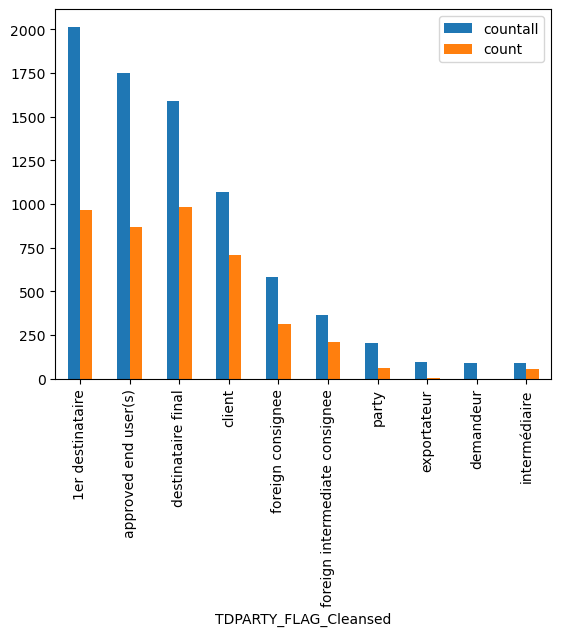

In [20]:
tp["TDPARTY_FLAG_Cleansed"]=tp.TDPARTY_FLAG.str.lower()
a=tp[tp.idcim==""].TDPARTY_FLAG_Cleansed.value_counts()
b=tp.TDPARTY_FLAG_Cleansed.value_counts()
m=b.to_frame().join(a.to_frame(),lsuffix='all')
m[0:10].plot.bar()

In [21]:
sp1["CleansedAddress"].fillna("",inplace=True)
cim["CleansedAddress"].fillna("",inplace=True)
tp["CleansedAddress"].fillna("",inplace=True)
corpusaddress=pd.concat([cim.CleansedAddress,tp.CleansedAddress,sp1.CleansedAddress])
corpusaddress=corpusaddress.dropna()

In [22]:
#Based on the corpus of name we create a matrix of association
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizeraddress = CountVectorizer(strip_accents="ascii")
features = vectorizeraddress.fit(corpusaddress)

tpaddressvect=vectorizer.transform(tp.CleansedAddress)
cimaddressvect=vectorizer.transform(cim.CleansedAddress)
sp1addressvect=vectorizer.transform(sp1.CleansedAddress)

# Renormalize so that if country is present twice in name and in country, it is counted only once

tpaddressvect=(tpaddressvect>0)*1
cimaddressvect=(cimaddressvect>0)*1
sp1addressvect=(sp1addressvect>0)*1

In [23]:
sp1.loc[30202]

supp_no                                                            F86816
supp_name                         ESG Elektroniksystem- und Logistik-GmbH
supp_address                                          Livry-Gargan-Str. 6
supp_postal_code                                                    82256
supp_city                                                Fürstenfeldbruck
supp_country_code                                                      DE
supp_country_name_en                                              Germany
supp_cage_code                                                        NaN
division                                                              ADS
all_text                [ADS]; F86816; ESG Elektroniksystem- und Logis...
index                                                               30202
NameCleansed                      esg elektroniksystem- und logistik-gmbh
CountryCleansed                                                   germany
CleansedAddress                livry-g

In [24]:
# Selection meilleur cnadidats sp1
tp["bestidsp1"]=""
tp["bestaddresssp1"]=""
tp["probaaddresssp1"]=""

tp["bestidcim"]=""
tp["bestaddresscim"]=""
tp["probaaddresscim"]=""

for index,corresponances in tp[tp.idsp1.str.contains(",").fillna(False)].idsp1.items():
    vect=[int(item)  for item in corresponances.split(",")[:-1]]
    similarityaddress=cosine_similarity(tpaddressvect[index],sp1addressvect[vect])
    argmaximisant=similarityaddress.argmax()
    indexmaximisant=vect[argmaximisant]
    bestaddress=sp1.loc[indexmaximisant,"CleansedAddress"]
    tp.loc[index,"bestidsp1"]=indexmaximisant
    tp.loc[index,"bestaddresssp1"]=bestaddress
    tp.loc[index,"probaaddresssp1"]=similarityaddress[0][argmaximisant]

for index,corresponances in tp[tp.idcim.str.contains(",").fillna(False)].idcim.items():
    vect=[int(item)  for item in corresponances.split(",")[:-1]]
    similarityaddress=cosine_similarity(tpaddressvect[index],cimaddressvect[vect])
    argmaximisant=similarityaddress.argmax()
    indexmaximisant=vect[argmaximisant]
    bestaddress=cim.loc[indexmaximisant,"CleansedAddress"]
    tp.loc[index,"bestidcim"]=indexmaximisant
    tp.loc[index,"bestaddresscim"]=bestaddress
    tp.loc[index,"probaaddresscim"]=similarityaddress[0][argmaximisant]



In [25]:
for index,corresponances in tp[(~tp.idsp1.str.contains(",").fillna(False)) & (~(tp.idsp1==""))].idsp1.items():
    indexmaximisant=int(corresponances)
    similarityaddress=cosine_similarity(tpaddressvect[index],sp1addressvect[vect])
    bestaddress=sp1.loc[indexmaximisant,"CleansedAddress"]
    tp.loc[index,"bestidsp1"]=indexmaximisant
    tp.loc[index,"bestaddresssp1"]=bestaddress
    tp.loc[index,"probaaddresssp1"]=similarityaddress[0][argmaximisant]

for index,corresponances in tp[(~tp.idcim.str.contains(",").fillna(False)) & (~(tp.idcim==""))].idcim.items():
    indexmaximisant=int(corresponances)
    similarityaddress=cosine_similarity(tpaddressvect[index],cimaddressvect[vect])
    bestaddress=cim.loc[indexmaximisant,"CleansedAddress"]
    tp.loc[index,"bestidcim"]=indexmaximisant
    tp.loc[index,"bestaddresscim"]=bestaddress
    tp.loc[index,"probaaddresscim"]=similarityaddress[0][argmaximisant]


tp.to_excel("ThirdParty-ProposedMatches.xlsx",float_format="%.2f")


In [26]:

tp[["NameCountryCleansed","cleanednamecountrycim",'candidatscim',"nbcandidatesonnamecim"]]
#tp[tp.TDPARTY_NAME.str.contains("gemrany")][["NameCountryCleansed","cleanednamecountrycim",'candidatscim',"nbcandidatesonnamecim"]]
#tp.loc[8613,["NameCountryCleansed","cleanednamecountrycim",'candidatscim',"nbcandidatesonnamecim","idcim"]]
tp[["TDPARTY_NAME","TDPARTY_COUNTRY",'candidatscim',"NameCountryCleansed","cleanednamecountrycim","nbcandidatesonnamecim","idcim","probacim"]].to_excel("CIM-pairing.xlsx")

In [27]:
min(similaritycim[8613][np.where(similaritycim[8613]>.82)])

0.8660254037844388

In [28]:
tpjoin=set(tp.TDPARTY_NAME.str.lower())
cimjoin=set(cim.Name.str.lower())

len(tpjoin.intersection(cimjoin))
tp.probacim[tp.probacim==""]=0
tp.probacim.astype(float)
len(tp[tp.probacim>.82].TDPARTY_NAME.str.lower().unique())



sp1join=set(sp1.supp_name.str.lower())

print("sp1",len(tpjoin.intersection(sp1join)))
tp.probasp1[tp.probasp1==""]=0
tp.probasp1.astype(float)
len(tp[tp.probasp1>.82].TDPARTY_NAME.str.lower().unique())
tp[tp.probasp1>0.82]



sp1 366


/tmp/ipykernel_228/3752751450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp.probacim[tp.probacim==""]=0
/tmp/ipykernel_228/3752751450.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tp.probasp1[tp.probasp1==""]=0


,FILENAME,LICENSE_NBR,TDPARTY_NAME,TDPARTY_ROLE,TDPARTY_COUNTRY,TDPARTY_ADDRESS,TDPARTY_ARP_ID,ARP_needreview,TDPARTY_FLAG,LICENSE_DIVISION,...,probasp1,cleanednamecountrysp1,nbcandidatesonnamesp1,TDPARTY_FLAG_Cleansed,bestidsp1,bestaddresssp1,probaaddresssp1,bestidcim,bestaddresscim,probaaddresscim
3,httpsextentintraairbusdscorpws02029Programtabs...,D1172598,ESG Elektroniksystem-und-Logistik-GmbH,NaN,Germany,Livry-Gargan-Strasse 6,"F86816,157017",OK,Approved end user(s),ADS;AC,...,1.0,,2,approved end user(s),30202,livry-gargan-str. 6 82256 fürstenfeldbruck,0.0,105,211 frankfurter ring 80807 münchen,0.0
4,PCOMPLIANCEECFranceMAWSLI21000931210009312310A...,210009312310,Airbus,NaN,France,PO BOX B75-08 - 2 rond point Emile Dewoitine,135873,OK,Exportateur/Fournisseur,AC,...,1.0,,6,exportateur/fournisseur,19150,2 rond point emile dewoitine 31707 blagnac,0.755929,1320,"2, rond-point emile dewoitine 31700 blagnac",0.845154
8,PCOMPLIANCEECFranceICTLIGLO15001031Version6LIG...,150010311260,T-SYSTEMS ITC IBERIA SA,NaN,Espagne,NaN,NaN,OK,1er destinataire,AC,...,1.0,,1,1er destinataire,20540,cl sancho de avila 110-130 08018 barcelona,0.0,,,
10,httpsextentintraairbusdscorpws02029Programtabs...,D1156402,Airbus Operations GmbH,NaN,Germany,Kreetslag 10,D8518,OK,Approved End User(s),ADS;AC,...,0.866025,,10,approved end user(s),11129,cl kreetslag 10 21129 hamburg,0.816497,1720,10 kreetslag 21129 hamburg,1.0
11,httpsextentintraairbusdscorpws02029Programtabs...,D1229720,Thales UK Limited,NaN,United Kingdom,"Manor Royal, Crawley","F85490,F85796",OK,Approved End User(s),ADS;AC,...,0.866025,,6,approved end user(s),40029,manor royal rh109ha crawley,0.707107,48,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8606,PCOMPLIANCEECFranceICTLIGLO15001031Version7LIG...,150010311270,Computacenter AG & Co KG,NaN,ALLEMAGNE,NaN,NaN,OK,1er destinataire,AC,...,0.866025,,2,1er destinataire,23188,sachsenkamp 4 20097 hamburg,0.0,1303,helbronner straße 165 70191 stuttgart,0.0
8607,PCOMPLIANCEECFranceICTLIGLO15001031Version7LIG...,150010311270,DIMENSION Data Germany AG & CO KG,NaN,ALLEMAGNE,NaN,NaN,OK,1er destinataire,AC,...,1.0,,2,1er destinataire,22699,horexstr. 7 61352 bad homburg,0.0,1303,helbronner straße 165 70191 stuttgart,0.0
8608,OCOMPLIANCEGRXAUTHORIZATIONSMILITARYEUROFIGHTE...,40141756,BAE SYSTEMS,NaN,VEREINIGTES KOENIGREICH,Warton Aerodrome,NaN,OK,Empfänger,AC,...,0.866025,,18,empfänger,9658,warton aerodrome pr4 1ax preston,1.0,501,"41, st. james place sw1a 1ns london",0.0
8609,OCOMPLIANCEGRXAUTHORIZATIONSMILITARYEUROFIGHTE...,40227391,BAE Systems,NaN,Vereinigtes Königreich,Samlesbury Aerodrome,NaN,OK,Empfänger,AC,...,0.866025,,18,empfänger,314,woodford aerodrome sk7 1qr woodford,0.0,501,"41, st. james place sw1a 1ns london",0.0


In [30]:
similarityaddresscim=cosine_similarity(tpaddressvect,cimaddressvect)
similarityaddresssp1=cosine_similarity(tpaddressvect,sp1addressvect)
print(np.where(similarityaddresscim>.9))
print(tp.iloc[10,:].CleansedAddress)
print(cim.iloc[434,:].CleansedAddress)
print("==>",tp.iloc[10,:].NameCountryCleansed)
print(cim.iloc[434,:].NameCountryCleansed)
print(cim.iloc[1568,:].NameCountryCleansed)
print(cim.iloc[1571,:].NameCountryCleansed)
print(cim.iloc[1720,:].NameCountryCleansed)

#print(globalsimilaritycim[10,1720])
#argmaxglobalsimilaritycim[10]

(array([  10,   10,   10, ..., 8613, 8613, 8613]), array([ 434, 1568, 1571, ..., 1661, 1720, 1867]))
kreetslag 10 21129 hamburg
kreetslag 10,  21129 hamburg
==> airbus operations  germany
mpca multi purpose mmuter aircraft  germany
airbus aerostructures  germany
airbus  germany
airbus operations  germany


In [35]:
globalsimilaritycim=similaritycim*2+similarityaddresscim
argmaxglobalsimilaritycim=np.argmax(globalsimilaritycim,axis=1)
secondglobalsimilaritycim=globalsimilaritycim.copy()

for i in range(len(argmaxglobalsimilaritycim)):
    secondglobalsimilaritycim[i,argmaxglobalsimilaritycim[i]]=0

secondargmaxglobalsimilaritycim=np.argmax(secondglobalsimilaritycim,axis=1)


premiereprop=[]
sdeprop=[]

ceilgreen=2.64
ceilamber=2.0
matchratecim=np.zeros(len(tp))

with open("proposition-cim.html", "w") as my_file:
    my_file.write("<head>")
    my_file.write("<style>")
    my_file.write(".green{background-color: #DAF7A6; }")
    my_file.write(".red{background-color:  #f7bccd ; }")
    my_file.write(".amber{background-color: #FFC300; }")
    my_file.write("</style>")
    my_file.write("<head>")
    my_file.write("<body>")
    my_file.write("<table>\n")
    my_file.write("<tr>\n")
    my_file.write("<th width=300>Name License Third party")
    my_file.write("</th>")
    my_file.write("<th width=400>Address License Third Party")
    my_file.write("</th>")
    my_file.write("<th width=300>Name CIM")
    my_file.write("</th>")
    my_file.write("<th width=400>Address CIM")
    my_file.write("</th>")
    my_file.write("<th width=30>Rating")
    my_file.write("</th>")
    my_file.write("</tr>")
      
    #argmaxglobalsimilaritycim
    bestmatch=[]
    for i in range(len(tp)):
        idxtp=tp.iloc[i,:].name
        j=argmaxglobalsimilaritycim[i]
        rate=globalsimilaritycim[i,j]
        matchratecim[i]=rate
        if rate>ceilgreen:
            style="green"
        elif rate>ceilamber:
            style="amber"
        else :
            style="red"
        my_file.write("<tr class=\""+style+"\">\n")
        idxcim=cim.iloc[j,:].name
        tupletpcim=(idxtp,idxcim)
        bestmatch.append(tupletpcim)
        my_file.write("<td rowspan=2>")
        my_file.write(tp.loc[idxtp,"TDPARTY_NAME"])
        my_file.write("</td>")
        my_file.write("<td rowspan=2>")
        my_file.write(tp.loc[idxtp,"CleansedAddress"])
        my_file.write("</td>")
        my_file.write("<td>")
        my_file.write(cim.loc[idxcim,"Name"])
        my_file.write("</td>")
        my_file.write("<td>")
        my_file.write(cim.loc[idxcim,"CleansedAddress"])
        my_file.write("</td>")
        my_file.write("<td>")
        my_file.write('{0:.2f}'.format(rate))
        my_file.write("</td>")
        my_file.write("</tr>\n")

        j=secondargmaxglobalsimilaritycim[i]
        rate=globalsimilaritycim[i,j]
        if rate>ceilgreen:
            style="green"
        elif rate>ceilamber:
            style="amber"
        else :
            style="red"
        my_file.write("<tr class=\""+style+"\">\n")
        idxcim=cim.iloc[j,:].name
        tupletpcim=(idxtp,idxcim)
        bestmatch.append(tupletpcim)
        my_file.write("<td>")
        my_file.write(cim.loc[idxcim,"Name"])
        my_file.write("</td>")
        my_file.write("<td>")
        my_file.write(cim.loc[idxcim,"CleansedAddress"])
        my_file.write("</td>")
        my_file.write("<td>")
        my_file.write('{0:.2f}'.format(rate))
        my_file.write("</td>")
        my_file.write("</tr>\n")

    my_file.write("</table>\n")
    my_file.write("</body>\n")
    my_file.close()

In [46]:
#plt.hist(matchratecim)
#plt.show()
sum(matchratecim>ceilgreen)/len(matchratecim)

0.06942187137218482

In [1]:
globalsimilaritysp1=similaritysp1*2+similarityaddresssp1
argmaxglobalsimilaritysp1=np.argmax(globalsimilaritysp1,axis=1)
secondglobalsimilaritysp1=globalsimilaritysp1.copy()

for i in range(len(argmaxglobalsimilaritysp1)):
    secondglobalsimilaritysp1[i,argmaxglobalsimilaritysp1[i]]=0

secondargmaxglobalsimilaritysp1=np.argmax(secondglobalsimilaritysp1,axis=1)


premiereprop=[]
sdeprop=[]

ceilgreen=2.4
ceilamber=2.0

matchratesp1=np.zeros(len(tp))


with open("proposition-sp1.html", "w") as sp1matchfile:
    sp1matchfile.write("<head>")
    sp1matchfile.write("<style>")
    sp1matchfile.write(".green{background-color: #DAF7A6; }")
    sp1matchfile.write(".red{background-color:  #f7bccd ; }")
    sp1matchfile.write(".amber{background-color: #FFC300; }")
    sp1matchfile.write("</style>")
    sp1matchfile.write("<head>")
    sp1matchfile.write("<body>")
    sp1matchfile.write("<table>\n")
    sp1matchfile.write("<tr>\n")
    sp1matchfile.write("<th width=300>Name License Third party")
    sp1matchfile.write("</th>")
    sp1matchfile.write("<th width=400>Address License Third Party")
    sp1matchfile.write("</th>")
    sp1matchfile.write("<th width=300>Name sp1")
    sp1matchfile.write("</th>")
    sp1matchfile.write("<th width=400>Address sp1")
    sp1matchfile.write("</th>")
    sp1matchfile.write("<th width=30>Rating")
    sp1matchfile.write("</th>")
    sp1matchfile.write("</tr>")
      
    #argmaxglobalsimilaritysp1
    bestmatch=[]
    for i in range(len(tp)):
 #       print(i)
        idxtp=tp.iloc[i,:].name
        j=argmaxglobalsimilaritysp1[i]
        rate=globalsimilaritysp1[i,j]
        matchratesp1[i]=rate
        if rate>ceilgreen:
            style="green"
        elif rate>ceilamber:
            style="amber"
        else :
            style="red"
        sp1matchfile.write("<tr class=\""+style+"\">\n")
        idxsp1=sp1.iloc[j,:].name
        tupletpsp1=(idxtp,idxsp1)
        bestmatch.append(tupletpsp1)
        sp1matchfile.write("<td rowspan=2>")
        sp1matchfile.write(tp.loc[idxtp,"TDPARTY_NAME"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td rowspan=2>")
        sp1matchfile.write(tp.loc[idxtp,"CleansedAddress"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td>")
        sp1matchfile.write(sp1.loc[idxsp1,"supp_name"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td>")
        sp1matchfile.write(sp1.loc[idxsp1,"CleansedAddress"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td>")
        sp1matchfile.write('{0:.2f}'.format(rate))
        sp1matchfile.write("</td>")
        sp1matchfile.write("</tr>\n")

        j=secondargmaxglobalsimilaritysp1[i]
        rate=globalsimilaritysp1[i,j]
        if rate>ceilgreen:
            style="green"
        elif rate>ceilamber:
            style="amber"
        else :
            style="red"
        sp1matchfile.write("<tr class=\""+style+"\">\n")
        idxsp1=sp1.iloc[j,:].name
        tupletpsp1=(idxtp,idxsp1)
        bestmatch.append(tupletpsp1)
        sp1matchfile.write("<td>")
        sp1matchfile.write(sp1.loc[idxsp1,"supp_name"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td>")
        sp1matchfile.write(sp1.loc[idxsp1,"CleansedAddress"])
        sp1matchfile.write("</td>")
        sp1matchfile.write("<td>")
        sp1matchfile.write('{0:.2f}'.format(rate))
        sp1matchfile.write("</td>")
        sp1matchfile.write("</tr>\n")

    sp1matchfile.write("</table>\n")
    sp1matchfile.write("</body>\n")
    sp1matchfile.close()

NameError: name 'similaritysp1' is not defined

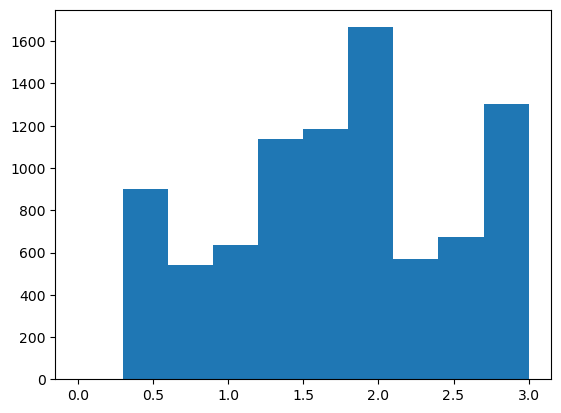

8614

In [48]:
plt.hist(matchratesp1)
plt.show()
sum(matchratesp1>ceilgreen)/len(matchratesp1)
len(tp)